In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import regex
from collections import Counter
from wordcloud import WordCloud
from underthesea import word_tokenize
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle


In [2]:
train_df = pd.read_csv("update_train_data.csv")
val_df   = pd.read_csv("update_val_data.csv")
test_df  = pd.read_csv("fix_test_data.csv")
print(train_df.head())
print(train_df["Label"].value_counts())


   Label                                           Maintext
0      0  Một số ủy viên Đoàn Chủ tịch Mặt trận Tổ quốc ...
1      1  S.T.T.D Tưởng Năng Tiến () - Dư luận, trong...
2      1  Nguyễn Thanh Giang  - Mồng 2 tháng 5 năm 2014,...
3      0  Bộ trưởng Công Thương mong muốn thu hút nhiều ...
4      0  Thủ tướng đề nghị Hà Nội phát huy tinh thần tự...
Label
0    472
1    377
Name: count, dtype: int64


In [3]:
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 849
Validation size: 171
Test size: 161


In [4]:
print("Train label distribution:")
print(train_df["Label"].value_counts())

print("\nValidation label distribution:")
print(val_df["Label"].value_counts())

print("\nTest label distribution:")
print(test_df["Label"].value_counts())



Train label distribution:
Label
0    472
1    377
Name: count, dtype: int64

Validation label distribution:
Label
0    93
1    78
Name: count, dtype: int64

Test label distribution:
Label
0    90
1    71
Name: count, dtype: int64


In [5]:
def plot_label_distribution(df, title):
    label_counts = df["Label"].value_counts().sort_index()
    
    plt.figure()
    bars = plt.bar(label_counts.index.astype(str), label_counts.values)
    
    plt.xlabel("Label (0 = Real, 1 = Fake)")
    plt.ylabel("Number of samples")
    plt.title(title)

    # Hiển thị số lượng trên mỗi cột
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            str(height),
            ha='center',
            va='bottom'
        )

    plt.show()


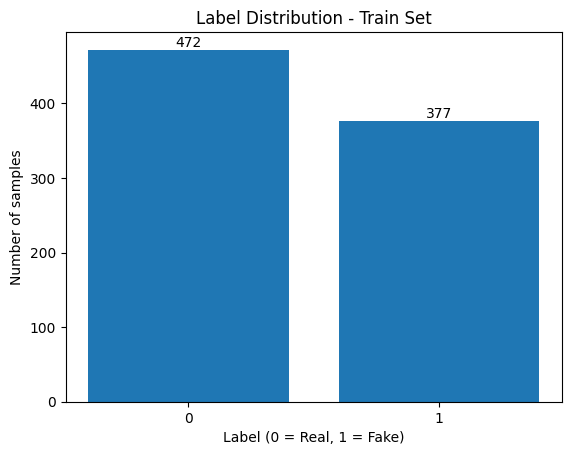

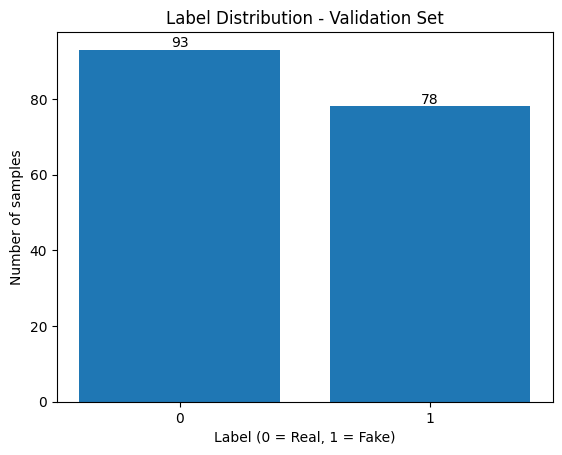

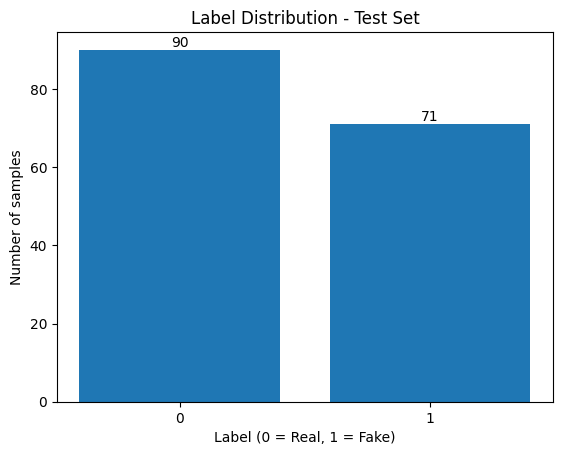

In [6]:
plot_label_distribution(train_df, "Label Distribution - Train Set")
plot_label_distribution(val_df,   "Label Distribution - Validation Set")
plot_label_distribution(test_df,  "Label Distribution - Test Set")


# EDA

In [7]:
label_counts = train_df["Label"].value_counts()
print(label_counts)

Label
0    472
1    377
Name: count, dtype: int64


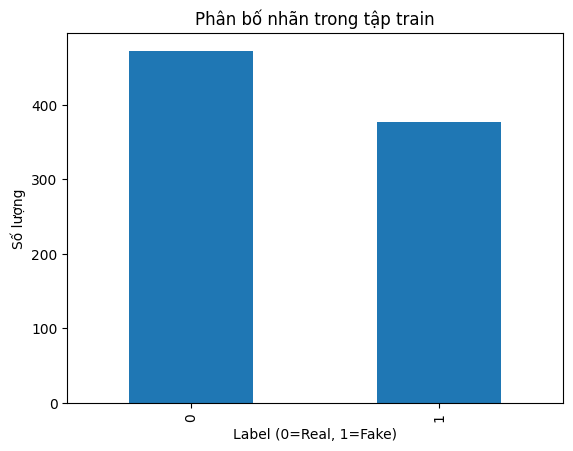

In [8]:
plt.figure()
label_counts.plot(kind="bar")
plt.title("Phân bố nhãn trong tập train")
plt.xlabel("Label (0=Real, 1=Fake)")
plt.ylabel("Số lượng")
plt.show()


# Preprocessing

In [9]:
VIETNAMESE_STOPWORDS = set([
    "là", "và", "của", "có", "cho", "một", "những", "các",
    "đã", "đang", "sẽ", "này", "đó", "với", "khi", "tại",
    "theo", "đến", "từ", "về", "trong", "ra", "như"
])

# KHÔNG loại các từ phủ định
NEGATION_WORDS = {"không", "chưa", "chẳng"}


In [10]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    # Xóa URL
    text = re.sub(r"http\S+|www\S+", " ", text)
    # Xóa email
    text = re.sub(r"\S+@\S+", " ", text)
    # Xóa số
    text = re.sub(r"\d+", " ", text)
    # Giữ chữ tiếng Việt
    text = regex.sub(r"[^\p{L}\s]", " ", text)
    # Chuẩn hóa khoảng trắng
    text = re.sub(r"\s+", " ", text).strip()
    tokens = word_tokenize(text, format="text").split()

    tokens = [
        w for w in tokens
        if (w not in VIETNAMESE_STOPWORDS) or (w in NEGATION_WORDS)
    ]
    return " ".join(tokens)
train_df["clean_text"] = train_df["Maintext"].apply(clean_text)
val_df["clean_text"]  = val_df["Maintext"].apply(clean_text)
test_df["clean_text"] = test_df["Maintext"].apply(clean_text)


In [11]:
train_df["text_length"] = train_df["clean_text"].apply(lambda x: len(x.split()))
print(train_df["text_length"].describe())

count     849.000000
mean      604.726737
std       543.607120
min         0.000000
25%       254.000000
50%       464.000000
75%       768.000000
max      4175.000000
Name: text_length, dtype: float64


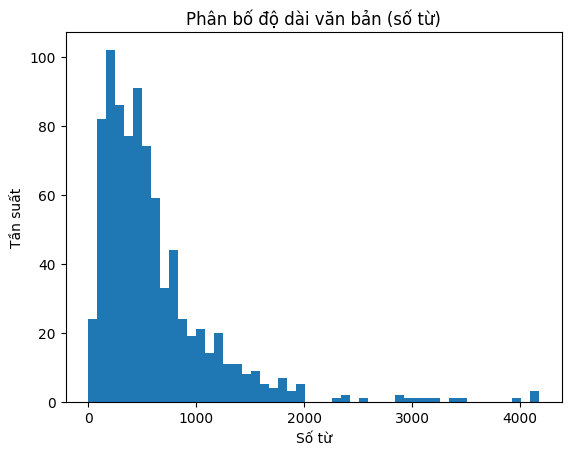

In [12]:
plt.figure()
plt.hist(train_df["text_length"], bins=50)
plt.title("Phân bố độ dài văn bản (số từ)")
plt.xlabel("Số từ")
plt.ylabel("Tần suất")
plt.show()


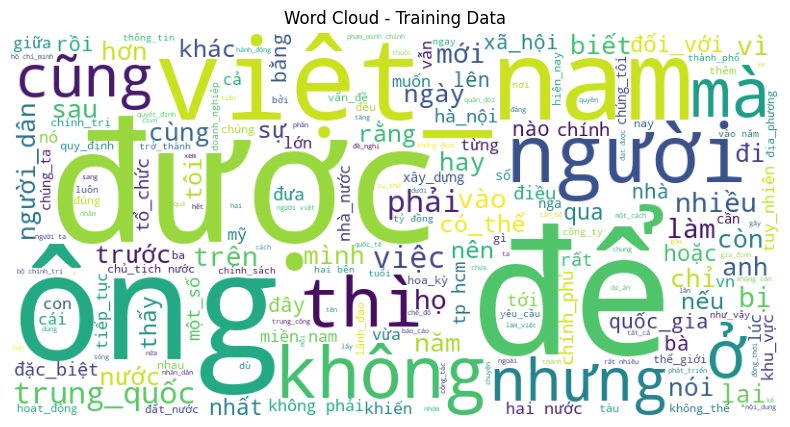

In [13]:
text_all = " ".join(train_df["clean_text"])

wc = WordCloud(
    width=800,
    height=400,
    background_color="white"
)

plt.figure(figsize=(10,5))
plt.imshow(wc.generate(text_all))
plt.axis("off")
plt.title("Word Cloud - Training Data")
plt.show()


In [14]:
fake_text = " ".join(train_df[train_df["Label"] == 1]["clean_text"])
real_text = " ".join(train_df[train_df["Label"] == 0]["clean_text"])

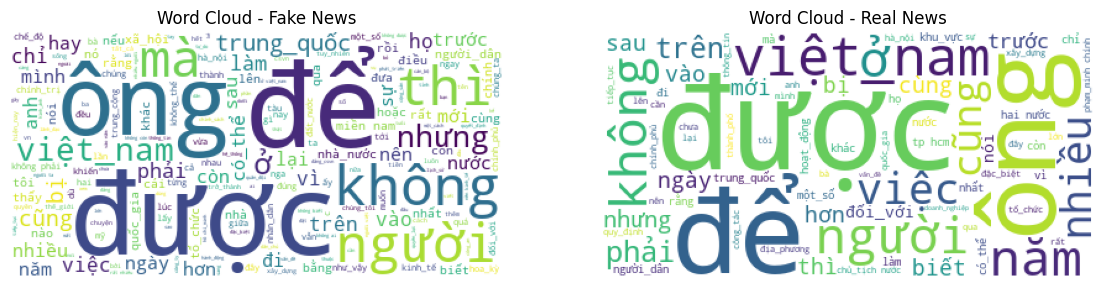

In [15]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(background_color="white").generate(fake_text))
plt.axis("off")
plt.title("Word Cloud - Fake News")
plt.subplot(1,2,2)
plt.imshow(WordCloud(background_color="white").generate(real_text))
plt.axis("off")
plt.title("Word Cloud - Real News")

plt.show()


In [16]:
def word_freq_by_label(df, word):
    fake = df[df["Label"] == 1]["clean_text"].str.contains(word).sum()
    real = df[df["Label"] == 0]["clean_text"].str.contains(word).sum()
    return fake, real

for w in ["ông", "để", "được"]:
    print(w, word_freq_by_label(train_df, w))


ông (np.int64(372), np.int64(465))
để (np.int64(333), np.int64(361))
được (np.int64(353), np.int64(409))


In [17]:
def extract_ngrams(text, n):
    words = text.split()
    return zip(*[words[i:] for i in range(n)])


In [18]:
bigrams = []

for text in train_df["clean_text"]:
    bigrams.extend(extract_ngrams(text, 2))

top_bigrams = Counter(bigrams).most_common(15)
print(top_bigrams)


[(('tp', 'hcm'), 392), (('không', 'phải'), 379), (('miền', 'nam'), 368), (('hai', 'nước'), 326), (('chủ_tịch', 'nước'), 303), (('vào', 'năm'), 257), (('hai', 'bên'), 253), (('tỷ', 'đồng'), 251), (('phạm_minh', 'chính'), 251), (('hồ', 'chí_minh'), 245), (('người', 'việt'), 236), (('bộ', 'chính_trị'), 230), (('không', 'được'), 229), (('không', 'còn'), 213), (('đạt', 'được'), 204)]


In [19]:
fake_bigrams = []
real_bigrams = []

for text in train_df[train_df["Label"] == 1]["clean_text"]:
    fake_bigrams.extend(extract_ngrams(text, 2))

for text in train_df[train_df["Label"] == 0]["clean_text"]:
    real_bigrams.extend(extract_ngrams(text, 2))

print("Top bigram - Fake News:")
print(Counter(fake_bigrams).most_common(10))

print("\nTop bigram - Real News:")
print(Counter(real_bigrams).most_common(10))


Top bigram - Fake News:
[(('miền', 'nam'), 338), (('không', 'phải'), 286), (('vào', 'năm'), 183), (('người', 'ta'), 180), (('người', 'việt'), 180), (('không', 'còn'), 175), (('không', 'ai'), 163), (('hồ', 'chí_minh'), 156), (('không', 'được'), 152), (('ở', 'việt_nam'), 152)]

Top bigram - Real News:
[(('tp', 'hcm'), 287), (('hai', 'nước'), 283), (('chủ_tịch', 'nước'), 249), (('phạm_minh', 'chính'), 207), (('thủ_tướng', 'phạm_minh'), 186), (('hai', 'bên'), 164), (('phó', 'thủ_tướng'), 151), (('nâng', 'cao'), 142), (('bộ', 'chính_trị'), 139), (('cấp', 'cao'), 137)]


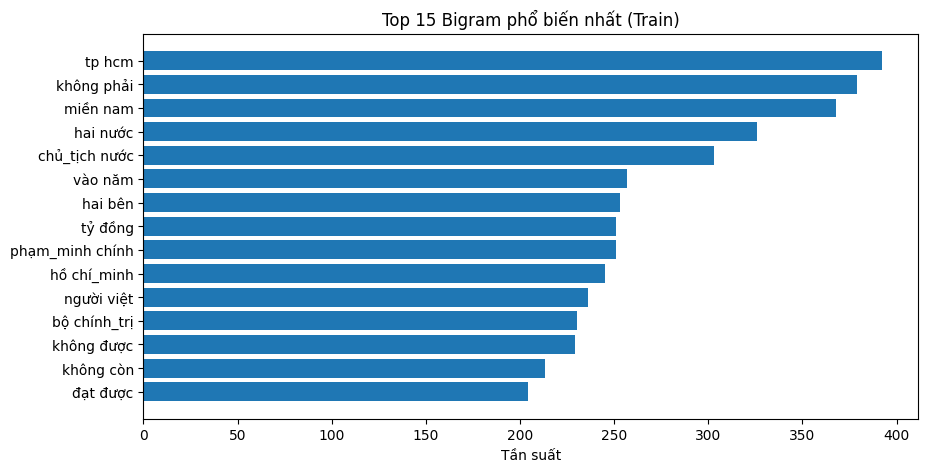

In [20]:
bigram_words = [" ".join(b) for b, _ in top_bigrams]
bigram_counts = [c for _, c in top_bigrams]

plt.figure(figsize=(10,5))
plt.barh(bigram_words, bigram_counts)
plt.gca().invert_yaxis()
plt.title("Top 15 Bigram phổ biến nhất (Train)")
plt.xlabel("Tần suất")
plt.show()


# Training and Evaluation

In [21]:
y_train = train_df["Label"]
y_val   = val_df["Label"]
y_test  = test_df["Label"]


In [22]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),   # unigram + bigram
    min_df=3,
    max_df=0.9
)

X_train = tfidf.fit_transform(train_df["clean_text"])
X_val   = tfidf.transform(val_df["clean_text"])
X_test  = tfidf.transform(test_df["clean_text"])


In [23]:
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)

    acc  = accuracy_score(y_val, val_pred)
    prec = precision_score(y_val, val_pred, pos_label=1)
    rec  = recall_score(y_val, val_pred, pos_label=1)
    f1   = f1_score(y_val, val_pred, pos_label=1)

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

In [24]:
results = []

nb  = MultinomialNB()
lr  = LogisticRegression(max_iter=1000)
svm = LinearSVC()

results.append(train_and_evaluate(lr,  "Logistic Regression"))
results.append(train_and_evaluate(svm, "SVM (LinearSVC)"))
results.append(train_and_evaluate(nb,  "Naive Bayes"))
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-score", ascending=False)


,Model,Accuracy,Precision,Recall,F1-score
1,SVM (LinearSVC),0.929825,0.912500,0.935897,0.924051
0,Logistic Regression,0.894737,0.884615,0.884615,0.884615
2,Naive Bayes,0.883041,0.822222,0.948718,0.880952


# So sánh mô hình

In [25]:
nb_f1  = train_and_evaluate(nb, "Naive Bayes")["F1-score"]
lr_f1  = train_and_evaluate(lr, "Logistic Regression")["F1-score"]
svm_f1 = train_and_evaluate(svm, "SVM (LinearSVC)")["F1-score"]

results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "SVM"],
    "F1-score (Val)": [nb_f1, lr_f1, svm_f1]
})

print(results.sort_values(by="F1-score (Val)", ascending=False))


                 Model  F1-score (Val)
2                  SVM        0.924051
1  Logistic Regression        0.884615
0          Naive Bayes        0.880952


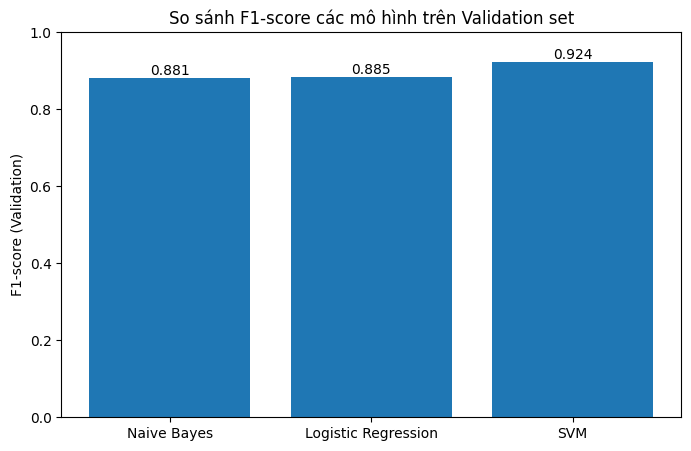

In [26]:
models = ["Naive Bayes", "Logistic Regression", "SVM"]
f1_scores = [nb_f1, lr_f1, svm_f1]

plt.figure(figsize=(8,5))
bars = plt.bar(models, f1_scores)

plt.ylabel("F1-score (Validation)")
plt.title("So sánh F1-score các mô hình trên Validation set")
plt.ylim(0, 1)

# Hiển thị giá trị trên cột
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom"
    )

plt.show()

In [27]:
best_model = svm

test_pred = best_model.predict(X_test)

print("===== TEST RESULT =====")
print("Accuracy:", accuracy_score(y_test, test_pred))
print("F1-score:", f1_score(y_test, test_pred))
print(classification_report(y_test, test_pred))


===== TEST RESULT =====
Accuracy: 0.9440993788819876
F1-score: 0.9403973509933775
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        90
           1       0.89      1.00      0.94        71

    accuracy                           0.94       161
   macro avg       0.94      0.95      0.94       161
weighted avg       0.95      0.94      0.94       161



In [28]:

def evaluate_overfit(model, X_train, y_train, X_val, y_val, X_test=None, y_test=None):
    datasets = {
        "Train": (X_train, y_train),
        "Validation": (X_val, y_val)
    }
    
    if X_test is not None and y_test is not None:
        datasets["Test"] = (X_test, y_test)
    
    results = {"Dataset": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}
    
    for name, (X, y) in datasets.items():
        y_pred = model.predict(X)
        results["Dataset"].append(name)
        results["Accuracy"].append(accuracy_score(y, y_pred))
        results["Precision"].append(precision_score(y, y_pred, pos_label=1))
        results["Recall"].append(recall_score(y, y_pred, pos_label=1))
        results["F1-score"].append(f1_score(y, y_pred, pos_label=1))
    
    results_df = pd.DataFrame(results)
    print(results_df)

# Sử dụng với mô hình tốt nhất của bạn
evaluate_overfit(best_model, X_train, y_train, X_val, y_val, X_test, y_test)


      Dataset  Accuracy  Precision    Recall  F1-score
0       Train  0.996466    0.99734  0.994695  0.996016
1  Validation  0.929825    0.91250  0.935897  0.924051
2        Test  0.944099    0.88750  1.000000  0.940397


Confusion Matrix:
[[81  9]
 [ 0 71]]


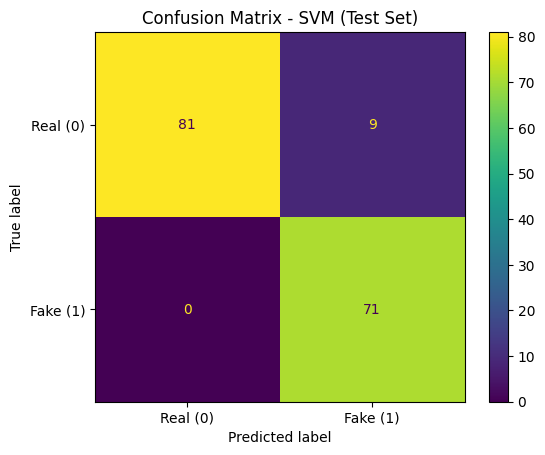

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)

print("Confusion Matrix:")
print(cm)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Real (0)", "Fake (1)"]
)

disp.plot()
plt.title("Confusion Matrix - SVM (Test Set)")
plt.show()

In [30]:
# Gộp train + validation
full_df = pd.concat([train_df, val_df])

X_full = tfidf.fit_transform(full_df["clean_text"])
y_full = full_df["Label"]

final_svm = LinearSVC()
final_svm.fit(X_full, y_full)

# Save
pickle.dump(tfidf, open("tfidf.pkl", "wb"))
pickle.dump(final_svm, open("model_svm.pkl", "wb"))

print(" Final model trained & saved")

 Final model trained & saved
